<a href="https://colab.research.google.com/github/2ovisa/AH2179/blob/main/project4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stop ahead prediction
- intressant för resenärer att veta hur stor förseningen blir vid sitt stop
- intressant för resenärer att veta hur stor förseningen är vid sin påstigande station

##Data Preparation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

#-------------------------------------------------data preprocessing------------------------------------------------------------------

url = 'https://raw.githubusercontent.com/zhenliangma/Applied-AI-in-Transportation/master/ProjectAssignmentData/Dataset-PT.csv'
df = pd.read_csv(url, header = 1)
#print(df.head(10))
#df.info()
#print(df.columns.tolist())

#df = df.iloc[:1000]



###Kolumner att droppa:
- Identifiers: Calender_date, route_id, bus_id (innehåller inte nödvändig information
- They who leak future knowledge: Arrival_delay (should be target)
- Dummies: To avoid multi collineraty one of the examples should be dropped. factor(temperature)Normal, (weather)normal, weekend, off-peak. *these become the baseline?*


In [ ]:
#skapa unika trippar
df = df.sort_values(['bus_id', 'Calendar_date', 'stop_sequence']).reset_index(drop=True)

df['trip_number'] = df.groupby(['bus_id','Calendar_date', 'stop_sequence']).cumcount()
df['unique_trip'] = (
    df['bus_id'].astype(str) + '_' +
    df['Calendar_date'].astype(str) + '_' +
    df['trip_number'].astype(str)
)


In [ ]:
#Dubbelkolla så att tripparna är unika och har count = 27
df.groupby('unique_trip')['stop_sequence'].agg(['min','max','count']).sort_values('count')


In [ ]:
#multi horizon targets
#df = df.sort_values(['unique_trip', 'stop_sequence'])

for h in [1,3,6,12]:
  df[f'arrival_delay_t+{h}'] = df.groupby('unique_trip')['arrival_delay'].shift(-h)

# ta bort rader utan target
targets = [f"arrival_delay_t+{h}" for h in [1, 3, 6, 12]]
df_h = df[df[targets].notna().all(axis=1)].copy()

*Why is arrival_delay used and not stop sequence?*
- *stop sequence is just an index telling which stop number in the trip. It only contains ordering, not delay information*
- *the code says "for stop i, the target is the arrival delay at stop i+1*

*this assumes each stop is ~5 minutes apart. If travel times vary a lot, then “t+5 min” might not really equal “next stop”*

In [ ]:
# 3. FEATURE ENGINEERING (temporala + dynamiska features)
#-------------------------------------------------
# Normaliserad stopp-position
df_h["stop_sequence_norm"] = df_h.groupby("unique_trip")["stop_sequence"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Stopp kvar till slutet
df_h["stops_remaining"] = df_h.groupby("unique_trip")["stop_sequence"].transform(
    lambda x: x.max() - x
)

# Differens i försening mot föregående stopp
df_h["delay_diff"] = df_h.groupby("unique_trip")["arrival_delay"].diff().fillna(0)

# Glidande medelvärde (3 stopp bakåt)
df_h["delay_ma3"] = df_h.groupby("unique_trip")["arrival_delay"].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

In [ ]:
unique_trips = df_h["unique_trip"].unique()
split_point = int(len(unique_trips) * 0.8)
train_trips = unique_trips[:split_point]
test_trips = unique_trips[split_point:]

# skapa mask
train_mask = df_h["unique_trip"].isin(train_trips)
test_mask = ~train_mask

In [ ]:
drop_cols = [
    "Calendar_date", "bus_id", "route_id", "arrival_time",
    "stop_sequence", "unique_trip", "new_trip", "trip_number"
]
df_h = df_h.drop(columns=[c for c in drop_cols if c in df_h.columns])

# Baseline dummies tas bort för att undvika multikollinearitet
to_drop = ["factor(weather)Normal", "factor(temperature)Normal",
           "factor(day_of_week)weekend", "factor(time_of_day)Off-peak"]
df_h = pd.get_dummies(df_h, drop_first=False)
df_h = df_h.drop(columns=[c for c in to_drop if c in df_h.columns], errors="ignore")


- *if stop_sequence is a freature, the model might cheat by just learning that higher stop numbers mean later in the trip*

In [ ]:
# --- features/targets ---
X = df_h.drop(["arrival_delay"] + targets, axis=1, errors="ignore")
y = df_h[targets]

In [ ]:
#skala
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test = X_scaled[train_mask], X_scaled[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

targets = ['arrival_delay', "arrival_delay_t+1", "arrival_delay_t+3", "arrival_delay_t+6", "arrival_delay_t+12"]


#filtrera bort rader utan target
df_h = df[df[targets].notna()]
X = df_h.drop(targets, axis=1)
y = df_h[targets]
# List of target columns

# Create subplots (5 rows, 1 column)
fig, axes = plt.subplots(len(targets), 1, figsize=(8, 20))

# Loop through targets and plot each on its own axis
for i, col in enumerate(targets):
    sns.histplot(df[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

#sns.histplot(x=df['arrival_delay'])
#sns.histplot(x=df['delay_1_stop'])
#sns.histplot(x=df['delay_3_stop'])
#sns.histplot(x=df['delay_6_stop'])
#sns.histplot(x=df['delay_12_stop'])

##Multi-output with KNN

In [ ]:
X_train.dtypes.value_counts()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor


model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Träna en enda multi-output RF
model = RandomForestRegressor(n_estimators=80, max_depth=15, random_state=42)
model.fit(X_train, y_train)

# Prediktion
y_pred = model.predict(X_test)



In [ ]:
#evaluate

mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
for col, score in zip(y.columns, mae):
    print(f"MAE for {col}: {score:.2f}")

MAE for arrival_delay_t+1: 21.06
MAE for arrival_delay_t+3: 37.71
MAE for arrival_delay_t+6: 55.34
MAE for arrival_delay_t+12: 81.59


KN
- MAE for arrival_delay_t+1: 27.19
- MAE for arrival_delay_t+3: 43.65
- MAE for arrival_delay_t+6: 61.55
- MAE for arrival_delay_t+12: 88.90

RF
- MAE for arrival_delay_t+1: 21.06
- MAE for arrival_delay_t+3: 37.71
- MAE for arrival_delay_t+6: 55.34
- MAE for arrival_delay_t+12: 81.59

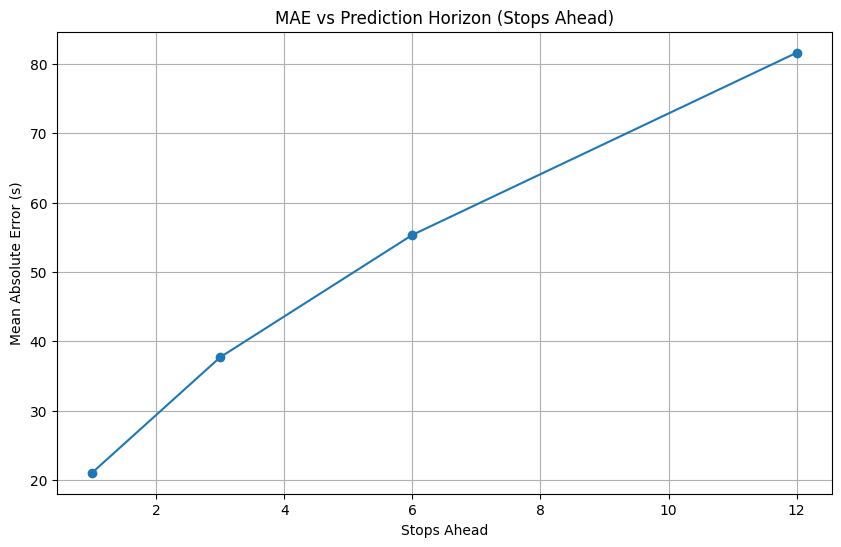

In [ ]:
#visualization
plt.figure(figsize=(10,6))
plt.plot([1,3,6,12], mae, marker='o')
plt.title("MAE vs Prediction Horizon (Stops Ahead)")
plt.xlabel("Stops Ahead")
plt.ylabel("Mean Absolute Error (s)")
plt.grid(True)
plt.show()

In [ ]:
# skapa samma features som vid modellträning
trip_id = df["unique_trip"].iloc[0]
trip_data = df[df["unique_trip"] == trip_id].sort_values("stop_sequence")

# ta bara kolumner som användes i modellen
trip_X = trip_data[X.columns.intersection(trip_data.columns)].copy()

# eventuellt skapa dummies på samma sätt som innan
trip_X = pd.get_dummies(trip_X)
trip_X = trip_X.reindex(columns=X.columns, fill_value=0)

# prediktion
y_trip_pred = model.predict(trip_X)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


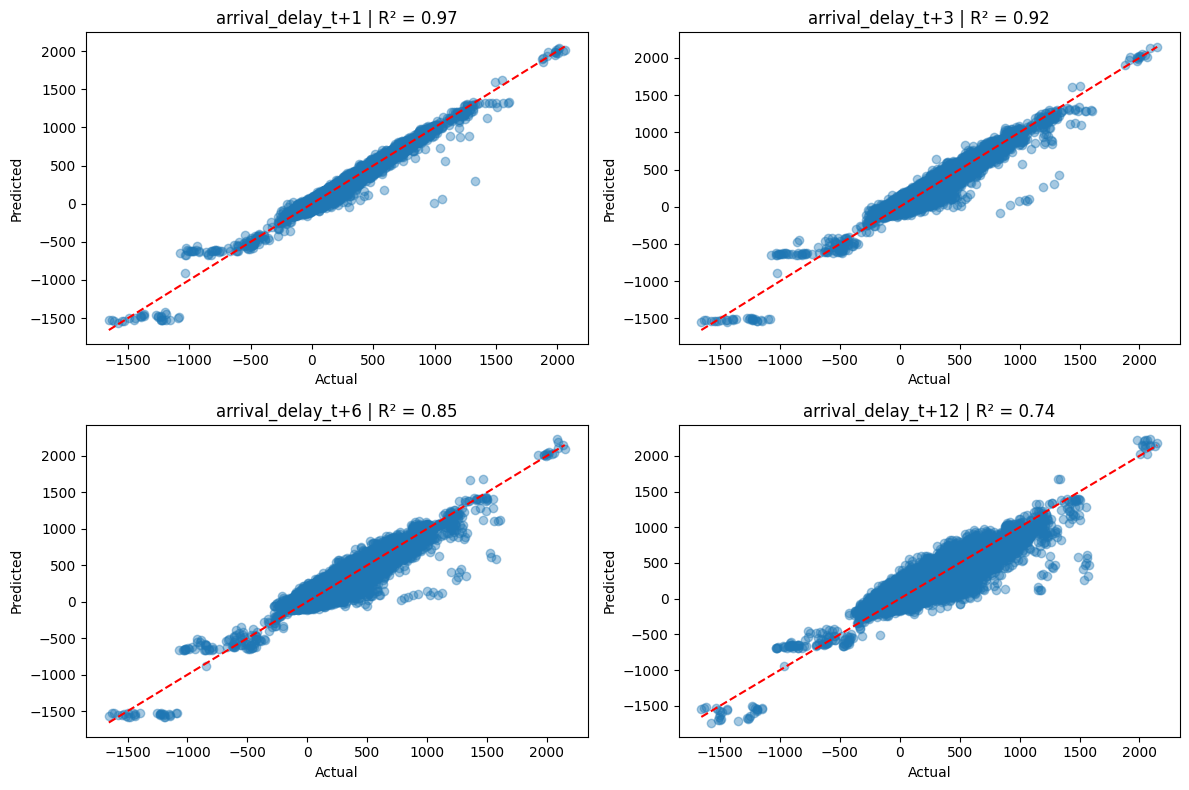

In [ ]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(y.columns):
    plt.subplot(2, 2, i+1)
    plt.scatter(y_test[col], y_pred[:, i], alpha=0.4)
    plt.plot([y_test[col].min(), y_test[col].max()],
             [y_test[col].min(), y_test[col].max()],
             "r--")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{col} | R² = {r2_score(y_test[col], y_pred[:, i]):.2f}")
plt.tight_layout()
plt.show()

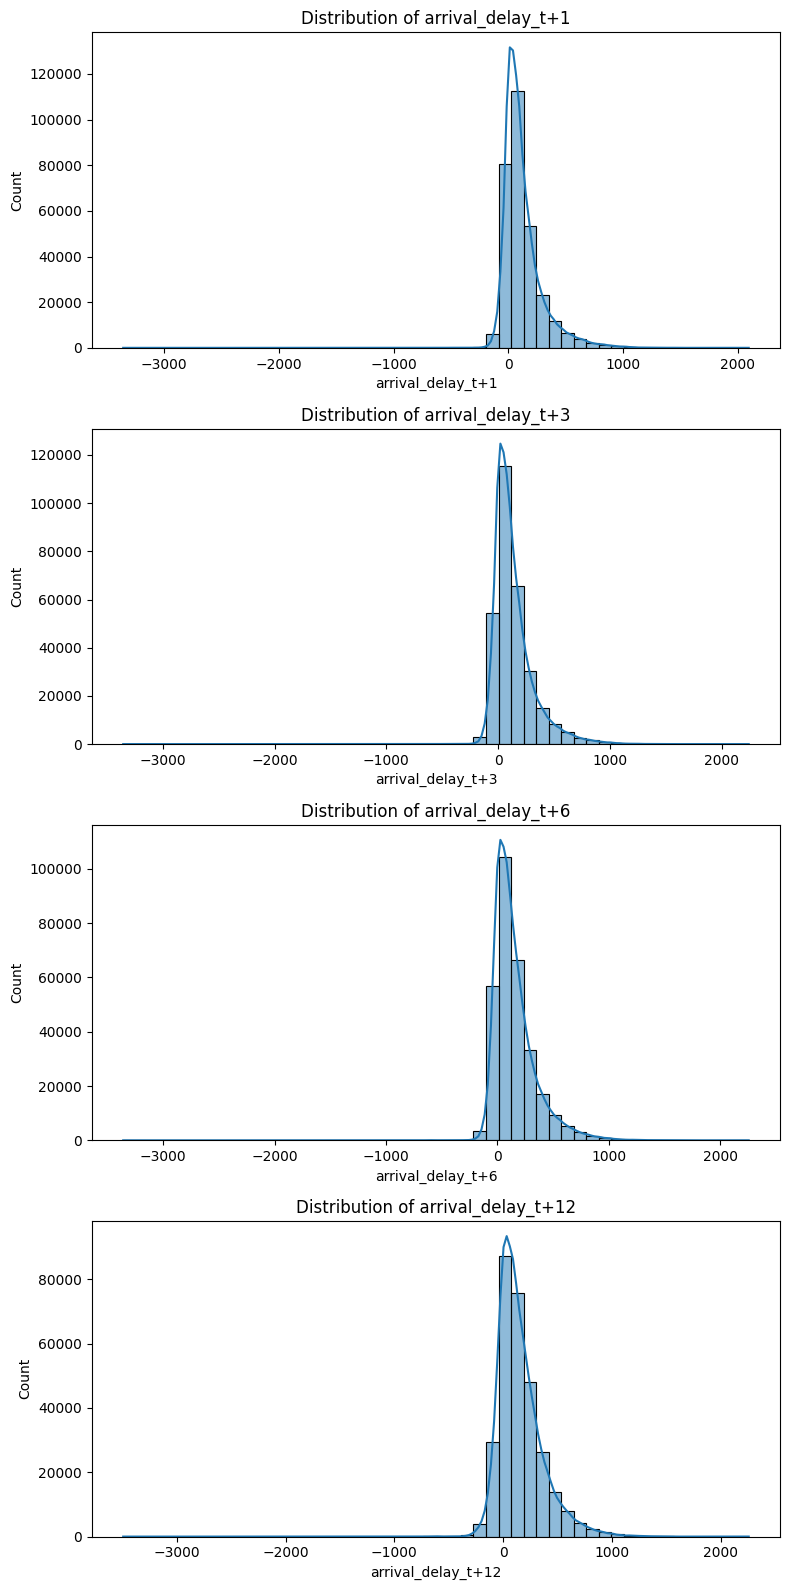

In [ ]:
#distributioncheck
fig, axes = plt.subplots(len(targets), 1, figsize=(8, 16))
for i, col in enumerate(targets):
    sns.histplot(df_h[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

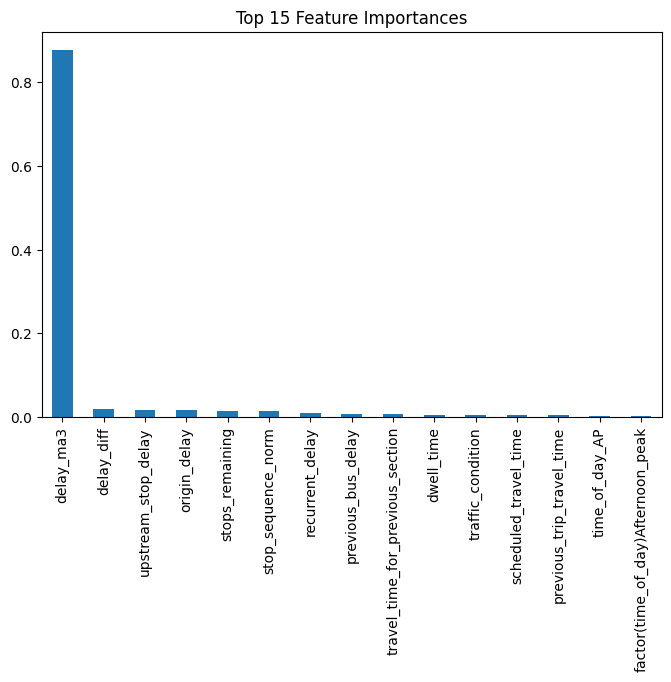

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

importances = model.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
feat_imp.head(15).plot(kind='bar')
plt.title("Top 15 Feature Importances")
plt.show()


MAE = the average absolute difference between the models predictions and the actual delay

- MAE for delay_t+1_stop: 34.00
- MAE for delay_t+3_stop: 46.54
- MAE for delay_t+6_stop: 54.66
- MAE for delay_t+12_stop: 56.01

This means that on average, the prediction for the next stop is off by 34 seconds.

Interpretations:
- Errors grow as the horizon length increases, which is expected since uncertainty accumulates further into the future


#Visualization

- *points above the line = overestimations, below = underestimations*